In [1]:
import requests
# Save data generators as file to colab working directory
# If we are using GitHub, we make sure we are using the "Raw" version of the code
url='https://raw.githubusercontent.com/NVDLI/LDL/main/pt_framework/utilities.py'
r=requests.get(url)

# We also make sure our filename is the same as how we want to import
with open('utilities.py', 'w') as f:
  f.write(r.text)

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, dataloader
import numpy as np
import matplotlib.pyplot as plt
from utilities import train_model

device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
EPOCHS=100
BATCH_SIZE=16

TRAIN_TEST_SPLIT=0.8
MIN=12
FILE_NAME='/content/book_store_sales.csv'

def readfile(file_name):
  file=open(file_name, 'r', encoding='utf-8')
  next(file)
  data=[]
  for line in (file):
    values=line.split(',')
    data.append(float(values[1]))
  file.close()
  return np.array(data, dtype=np.float32)


# Read data and split up into train and test data

sales=readfile(FILE_NAME)
months=len(sales)
split=int(months*TRAIN_TEST_SPLIT)
train_sales=sales[0:split]
test_sales=sales[split:]

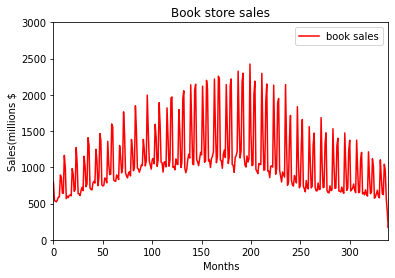

In [4]:
# Plot dataset
x=range(len(sales))
plt.plot(x, sales, 'r-', label='book sales')
plt.title('Book store sales')
plt.axis([0, 339, 0.0, 3000.0])
plt.xlabel('Months')
plt.ylabel('Sales(millions $')
plt.legend()
plt.show()

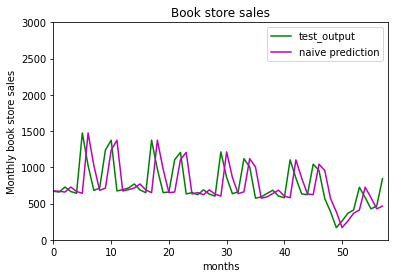

In [5]:
# Plot naive prediction
test_output=test_sales[MIN:]
naive_prediction=test_sales[MIN-1:-1]
x=range(len(test_output))
plt.plot(x, test_output, 'g-', label='test_output')
plt.plot(x, naive_prediction, 'm-', label='naive prediction')
plt.title('Book store sales')
plt.axis([0, len(test_output), 0.0, 3000.0])
plt.xlabel('months')
plt.ylabel('Monthly book store sales')
plt.legend()
plt.show()

In [6]:
# Standardize train and test data
# Use only training seasons to compute mean and stddev
mean=np.mean(train_sales)
stddev=np.std(train_sales)
train_sales_std=(train_sales - mean)/stddev
test_sales_std=(test_sales-mean)/stddev

In [7]:
# Create train examples
train_months=len(train_sales)
train_X=np.zeros((train_months-MIN, train_months-1, 1), dtype=np.float32)
train_y=np.zeros((train_months-MIN, 1), dtype=np.float32)
for i in range(0, train_months-MIN):
  train_X[i, -(i+MIN):, 0] = train_sales_std[0:i+MIN]
  train_y[i, 0] = train_sales_std[i+MIN]

# Create test examples
test_months=len(test_sales)
test_X=np.zeros((test_months-MIN, test_months-1, 1), dtype=np.float32)
test_y=np.zeros((test_months-MIN, 1), dtype=np.float32)
for i in range (0, test_months-MIN):
  test_X[i, -(i+MIN):, 0]=test_sales_std[0:i+MIN]
  test_y[i, 0] = test_sales_std[i+MIN]

# Create dataset objects
trainset=TensorDataset(torch.from_numpy(train_X).clone(), torch.from_numpy(train_y))
testset=TensorDataset(torch.from_numpy(test_X).clone(), torch.from_numpy(test_y))

In [8]:
# Custom layer that retreives only last time step from RNN output
class LastTimestep(nn.Module):
  def forward(self, inputs):
    return inputs[1][0]

# Create RNN model
model=nn.Sequential(
    nn.RNN(1, 128, nonlinearity='relu', batch_first=True),
    LastTimestep(),
    nn.Linear(128, 1)
)

# Loss function and optimizer
optimizer=torch.optim.Adam(model.parameters())
loss_function=nn.MSELoss()

# Train model
train_model(model, device, EPOCHS, BATCH_SIZE, trainset, testset, optimizer, loss_function, 'mae')

Epoch 1/100 loss: 0.9367 - mae: 0.7303 - val_loss: 1.1523 - val_mae: 0.8339
Epoch 2/100 loss: 0.8482 - mae: 0.6729 - val_loss: 0.8345 - val_mae: 0.7133
Epoch 3/100 loss: 0.6645 - mae: 0.5736 - val_loss: 0.2760 - val_mae: 0.3247
Epoch 4/100 loss: 0.5481 - mae: 0.5405 - val_loss: 0.5573 - val_mae: 0.5612
Epoch 5/100 loss: 0.5047 - mae: 0.5360 - val_loss: 0.3576 - val_mae: 0.4095
Epoch 6/100 loss: 0.4684 - mae: 0.4883 - val_loss: 0.4123 - val_mae: 0.4505
Epoch 7/100 loss: 0.4302 - mae: 0.4850 - val_loss: 0.3786 - val_mae: 0.4452
Epoch 8/100 loss: 0.4496 - mae: 0.4954 - val_loss: 0.2407 - val_mae: 0.3144
Epoch 9/100 loss: 0.4254 - mae: 0.4765 - val_loss: 0.3029 - val_mae: 0.3955
Epoch 10/100 loss: 0.3590 - mae: 0.4537 - val_loss: 0.2315 - val_mae: 0.2976
Epoch 11/100 loss: 0.3409 - mae: 0.4481 - val_loss: 0.3123 - val_mae: 0.3511
Epoch 12/100 loss: 0.6458 - mae: 0.5948 - val_loss: 0.3261 - val_mae: 0.3634
Epoch 13/100 loss: 0.8468 - mae: 0.6404 - val_loss: 0.9034 - val_mae: 0.7561
Epoch 14

[0.07862375545151093, 0.1377792190760374]

In [10]:
# Create naive prediction based on standardized data
test_putput=test_sales_std[MIN:]
naive_prediction=test_sales_std[MIN-1:-1]
mean_squared_error=np.mean(np.square(naive_prediction-test_output))
mean_abs_error=np.mean(np.abs(naive_prediction-test_putput))
print('naive test mse: ', mean_squared_error)
print('naive test mean abs: ', mean_abs_error)

naive test mse:  635686.44
naive test mean abs:  0.48052385


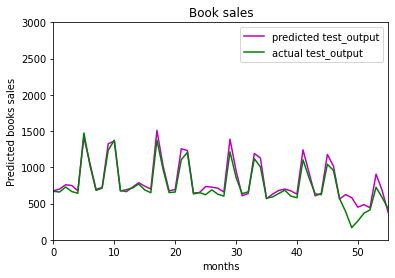

In [11]:
# Use trained model to predict the test data
inputs=torch.from_numpy(test_X)
inputs=inputs.to(device)
outputs=model(inputs)
predicted_test=outputs.cpu().detach().numpy()

# De-standardize output
predicted_test=np.reshape(predicted_test, (len(predicted_test)))
predicted_test=predicted_test*stddev+mean

# Plot test prediction

x=range(len(test_sales)-MIN)
plt.plot(x, predicted_test, 'm-', label='predicted test_output')
plt.plot(x, test_sales[-(len(test_sales)-MIN):], 'g-', label='actual test_output')
plt.title('Book sales')
plt.axis([0, 55, 0.0, 3000.0])
plt.xlabel('months')
plt.ylabel('Predicted books sales')
plt.legend()
plt.show()